# Session 4: Policy-gradient to The Moon

## Setups

In [1]:
# #uncomment only if you're running from google colab
# !git clone https://github.com/Datatouille/rl-workshop
# !mv rl-workshop/* .
# !ls

# #gym
# !pip install gym #For full installations, see https://github.com/openai/gym#installation

# #displays
# !pip install pyvirtualdisplay
# !sudo apt-get install xvfb

# #torch and numpy
# !pip install numpy 
# !pip install torch torchvision
# import torch
# torch.__version__

## Imports

In [2]:
%matplotlib inline

#environments
import gym
from solutions.environments import Gridworld

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical
#use cuda 0 if available; assuming 1 gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#misc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime
from collections import Counter, deque
import warnings
warnings.filterwarnings("ignore")

MODEL_PATH = 'models/'

## Animation Imports

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from pyvirtualdisplay import Display

#display
display = Display(visible=0, size=(512, 512))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

## Recap: Reinforcement Learning with Discrete States and Actions

Environments we have solved so far:
* Gridworld
* Blackjack-v0
* Taxi-v2

**Coding Assignment** What do they have in common? Find out what are the states and actions of each environment above.

In [4]:
#create environments
gridworld_env = Gridworld()
bj_env = gym.make('Blackjack-v0')
taxi_env = gym.make('Taxi-v2')

'''
Write your code here
'''

gridworld_env.state_space, bj_env.observation_space, taxi_env.observation_space

([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)],
 Tuple(Discrete(32), Discrete(11), Discrete(2)),
 Discrete(500))

**Hints** 
* `env.reset()` returns the initial state of an environment.
* `env.action_space` returns the action space of the environment.
* `env.observation_space` or `env.state_space` returns the state space of the environment.

## What Got You Here Will Not Take You There

So far our methods of finding the optimal policy has been:

1. Predict the action values given a state using either **a sample of transitions (Monte Carlo)** or **previous action values (Temporal Difference)**.
2. Store those values in a dictionary `Q[state][action]`
3. To perform an optimal action, choose the action index which gives the highest action value in the dictionary.

But what if we have infinitely many states?

## [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/)

One of the most influential articles on deep reinforcement is Andrej Karpathy's [Deep Reinforcement Learning: Pong from Pixels](https://karpathy.github.io/2016/05/31/rl/), where he details how to train an agent that learns to play Atari Pong from raw pixels using a technique called **policy gradient**. This session will borrow heavily from this article as well as [a lecture by David Silver](http://www0.cs.ucl.ac.uk/staff/D.Silver/web/Teaching_files/pg.pdf).

In this session, we will use **vanilla policy gradient** to try to guide the lunar module to a smooth landing. Here is how a random episode of the environment plays out:

In [5]:
env = gym.make('LunarLander-v2')
state = env.reset()
score = 0
t=0
frames = []

while True:
    action = np.random.choice(range(4))
    state, reward, done, info = env.step(action)
    t+=1
    score+=reward
    
    frames.append(env.render(mode = 'rgb_array'))
    if done: break
print(f'Done in {t} timsteps with score {score}.')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Done in 104 timsteps with score -370.2394225180608.


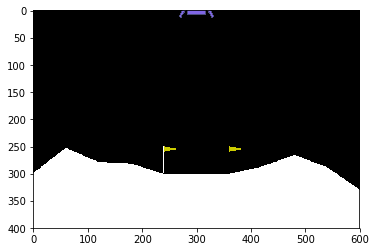

In [6]:
#animate frames
patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 1)
HTML(ani.to_jshtml())

**Coding Assignment** Before we dive in, let us do some warm-up exercises of finding out more about `LunarLander-v2`

* State space
* Action space
* Rewards
* How many episodes on average with random actions
* Render one frame and see how it looks like

In [7]:
#create environment
env = gym.make('LunarLander-v2')
env.reset()

'''
Write your code here
'''


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


'\nWrite your code here\n'

## Vanilla Policy Gradient aka REINFORCE aka Stochastic Policy Gradient aka Vanilla Policy Gradient

The gist of it is that instead of using the three steps we have done so far, we do:

1. Get rid of the Q dictionary altogether.
2. Use a neural network called **policy network** that takes the input of state (pixels) and outputs which action to take as our policy.
3. Get **a sample of transitions and discounted rewards** based on that neural network.
4. Optimize the policy network to maximize the **expected discounted rewards** using **gradient ascent**.

<img src="img/pong_pg.png" alt="Pong Policy Gradient"/>

### Things to Code Up

<img src="img/policygradient.png" alt="PG"/>

* `play_episode` function to collect some trajectories with some number of timesteps
* `discounted_rewards` function to calculate discounted returns to be used as baseline
* `surrogate` function to estimate the surrogate function; for each trajectory we have, find the sum of 

$$log(probability_{action}) * rewards_{discounted}$$

* Perform gradient ascent treating surrogate function as our "loss" to update the policy network.

## Policy Network

We use a policy network that takes an input of state and output the probability of taking an action directly. That is, we are not estimating the action value function $Q(s,a)$ but directly the policy function $\pi(a|s)$.

In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, seed = 1412):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.head = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        prob = F.softmax(self.head(x),1)
        dist = Categorical(prob)
        return(dist)
    
#initiate random policy
policy = PolicyNetwork(8,4,32)
optimizer = optim.Adam(policy.parameters(), lr=5e-3)

In [9]:
#policy
x = torch.FloatTensor(env.reset()).unsqueeze(0)
prob = policy(x)
prob

Categorical(probs: torch.Size([1, 4]))

**Coding Assignment** Use the randomly initiated policy network to play the game for 30 episodes. 
* What is the average reward across all episodes?
* How many times the agent chose each action?

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.



-693.0384805650414
Counter({2: 3506})


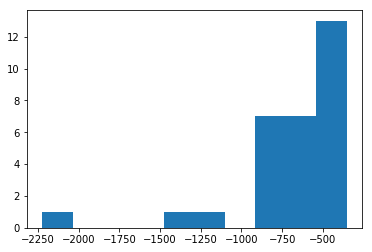

In [10]:
env = gym.make('LunarLander-v2')

scores = []
actions = []
ts = []

for i in tqdm_notebook(range(30)):
    #initial state
    state = env.reset()
    
    score = 0
    t = 0
    while True:
        t+=1

        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        '''
        Write codes to get probability and choose action here
        '''
        
        #record action
        actions.append(action)
        #environment step
        next_state, reward, done, info = env.step(action)
        #record score
        score+=reward
        #advance state
        state = next_state
        if done: break
    #append scores
    scores.append(score)
    ts.append(t)
    
plt.hist(scores)
print(np.mean(scores))
print(Counter(actions))

(array([14.,  5.,  5.,  1.,  2.,  2.,  0.,  0.,  0.,  1.]),
 array([ 72. ,  94.6, 117.2, 139.8, 162.4, 185. , 207.6, 230.2, 252.8,
        275.4, 298. ]),
 <a list of 10 Patch objects>)

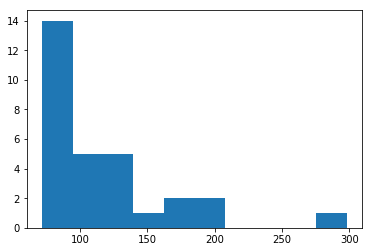

In [11]:
plt.hist(ts)

## Trajectories

With Monte Carlo methods, we collect all state-action pairs in an episode then update the Q dictionary once the episode ends. It is not very efficient since we always have to wait for the end of the episode. Here instead we will come up with an arbitrary number of timesteps and treat it as though it is an episode, calling it **trajectory** without having to wait for the `done` flag.

In [12]:
#for a single episode
def play_episode(policy, env, t_max=2000, nb_episode = 1):
    
    #each trajectory
    states= []
    actions = []
    log_probs = []
    rewards = []
    dones = []
    
    for e in range(nb_episode):
        #initialize state
        state = env.reset()
        for t in range(t_max):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            #get action and log prob
            dist = policy(state_tensor)
            action = dist.sample()
            log_prob = dist.log_prob(action) #do not detach from graph as we need this for computing loss
            action = action.item()

            #environment step
            next_state, reward, done, info = env.step(action)

            #append trajectories
            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            dones.append(done)

            #advance to next state
            state = next_state

            #break if done
            if done: break
                
    trajectory = (states, actions, log_probs, rewards, dones)
    return(trajectory)

In [13]:
trajectory = play_episode(policy, env, t_max = 2)
len(trajectory)

5

In [14]:
#see what's in the trajectory: states, actions, log_probs, rewards, dones
trajectory

([array([-0.00342827,  0.93222314, -0.34726102, -0.55936489,  0.0039793 ,
          0.07865997,  0.        ,  0.        ]),
  array([-0.00679226,  0.92345343, -0.33868182, -0.58465137,  0.00623903,
          0.04519966,  0.        ,  0.        ])],
 [3, 2],
 [tensor([-1.4608], grad_fn=<SqueezeBackward1>),
  tensor([-1.0877], grad_fn=<SqueezeBackward1>)],
 [-1.1081813615793397, 2.333917875323732],
 [False, False])

## Discounted Rewards

If you have noticed, we do not have any loss function to optimize. In fact, we will **NOT** be using any loss function in a traditional supervised deep learning sense but instead use **discounted rewards** as a baseline to optimize our policy network. We denote this with $R(\tau)$ where $\tau$ is a given trajectory.

**Coding Assignment** Add code to normalize the discounted rewards `g` with the discounted rewards in given trajectory.

In [15]:
def discounted_rewards(rewards, dones, gamma=0.99, normalized=True):
    g = 0
    returns = []
    #iterate from the last reward first; e.g. rewards = [0,1,2]
    #we iterate from 2, 1, 0
    for i in reversed(range(len(rewards))):
        #calculate discounted reward at timestep i
        #discounted reward = current reward + gamma * discounted reward from next timestep i+1
        #check if it's done then don't add up future discounted reward 
        g = rewards[i] + gamma * g * (1-dones[i])
        #insert this in the front of the array (since we are doing things in reverse)
        returns.insert(0, g)
    returns = np.array(returns)
        
    '''
    Write your code here
    '''
    if normalized:
        returns_avg = np.mean(returns)
        returns_std = np.std(returns)
        returns_std = max(1e-8, returns_std)
        returns_normalized = (returns - returns_avg) / (returns_std)
        returns = returns_normalized

    return(returns)

In [16]:
states, actions, log_probs, rewards, dones = play_episode(policy, env, t_max = 300)
rewards[-5:]

[-0.729930881846417,
 6.477606244830185,
 15.442890948337265,
 0.3477651447470589,
 -100]

In [17]:
discounted_rewards(rewards,dones, gamma=1, normalized=False)[-5:]

array([ -78.46166854,  -77.73173766,  -84.20934391,  -99.65223486,
       -100.        ])

## Surrogate Function and Gradient Ascent

The last and most important step is to optimize the policy network so that given a state, it will be more likely to perform an action that would maximize the **expected discounted rewards** $U(\theta)$ also called **surrogate function**:

$$U(\theta) = \sum_{\tau} P(\tau;\theta) R(\tau) = \frac{1}{m}\sum_{i=1}^{m} \sum_{t=0}^{H}log\pi_{\theta}(a^i_t|s^i_t)R(\tau^i) = \frac{1}{m}\sum_{i=1}^{m} \sum_{t=0}^{H}log\pi_{\theta}(a^i_t|s^i_t)R(\tau^i)$$

where
* $\tau$ is a trajectory
* $\theta$ is a set of parameters for the policy network
* $P(\tau; \theta)$ is the probability of trajectory $\tau$ given parameters $\theta$
* $R(\tau)$ is the discounted rewards of trajectory $\tau$
* $i$ denotes a trajectory
* $t$ denotes a timestep within a trajectory

In [18]:
def surrogate(rewards, dones, log_probs, gamma = 0.99, normalized=True):
    #get discounted rewards
    gs = discounted_rewards(rewards, dones, gamma, normalized)
    
    #loss is (log) probability of doing an action times its discounted (normalized) rewards
    loss = log_probs * gs
    
    #minus sign for telling pytorch we are doing gradient **ascent**
    return(-loss.sum())

In [19]:
loss = surrogate(rewards, dones, log_probs, gamma=0.99,normalized=True)
loss

tensor([-1.1552], grad_fn=<NegBackward>)

## Training

In [30]:
env = gym.make('LunarLander-v2')
policy = PolicyNetwork(8,4,128)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [31]:
# keep track of progress
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
losses = []
losses_deque = deque(maxlen=100) 
moving_losses = []
t_max = 500

state_time = datetime.now()
for e in tqdm_notebook(range(2000)):
    #use longer episodes to train as time goes on
    if (len(scores) > 0):
        if (scores[-1] > 0): t_max = 2000
        
    # collect trajectories
    states, actions, log_probs, rewards, dones = play_episode(policy, env, t_max=500, nb_episode=1)

    #calculate loss
    loss = surrogate(rewards, dones, log_probs, gamma=0.99, normalized=True)


    #run optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #collect score
#     states, actions, log_probs, rewards, dones = play_episode(policy, env, t_max=2000, nb_episode=1)
    score = sum(rewards)
    
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
    
    losses.append(loss.item())
    losses_deque.append(loss.item())
    moving_losses.append(np.mean(losses_deque))
        
    #solved at 200; easy solve at 100
    if moving_scores[-1] > 200: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break
    
    #print every few episodes
    if (e+1) % 100 ==0: 
        print(f'Episod {e+1}: Moving avg {moving_scores[-1]}; Surrogate {moving_losses[-1]}')

Episod 100: Moving avg -218.89998778557143; Surrogate -1.2492371886968612
Episod 200: Moving avg -144.00810387974383; Surrogate -1.9294422352313996
Episod 300: Moving avg -79.06557975414168; Surrogate -9.016937376111747
Episod 400: Moving avg -11.728072611405628; Surrogate -13.669415559470654
Episod 500: Moving avg 33.527354946489396; Surrogate -22.23169690191746
Episod 600: Moving avg 42.350748277909275; Surrogate -35.83726419687271
Episod 700: Moving avg 24.00460802683165; Surrogate -32.6690354347229
Episod 800: Moving avg -1.4421121064702682; Surrogate 8.880721638053656
Episod 900: Moving avg 31.145120198423907; Surrogate -12.048041505813599
Episod 1000: Moving avg 53.31422644763124; Surrogate -20.501118981838225
Episod 1100: Moving avg 41.315264875882264; Surrogate -8.441303838342428
Episod 1200: Moving avg 107.125950437205; Surrogate -27.173824037313462
Episod 1300: Moving avg 146.81277595489442; Surrogate -33.14115178078413
Episod 1400: Moving avg 185.4296008262907; Surrogate -62

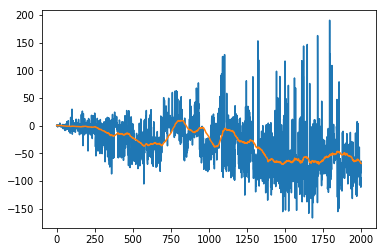

In [34]:
plt.plot(losses)
plt.plot(moving_losses)

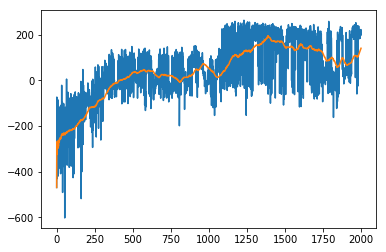

In [35]:
plt.plot(scores)
plt.plot(moving_scores)

## Test Agent

In [36]:
#somehow you need to do the animation import it again otherwise it wouldn't work
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from pyvirtualdisplay import Display

#display
display = Display(visible=0, size=(512, 512))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [37]:
print('x')

x


In [ ]:
score = 0
t=0
frames = []

env = gym.make('LunarLander-v2')
state = env.reset()
for i in tqdm_notebook(range(2000)):
    #get action
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    dist = policy(state_tensor)
    action = dist.sample().item()
    
    #env step
    state, reward, done, info = env.step(action)
    
    #book keeping
    t+=1
    score+=reward
    
    #break if done
    if done: break
    
    #append frame
    frames.append(env.render(mode = 'rgb_array'))
print(f'Done in {t} timsteps with score {score}.')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Bonus: How to Derive Gradients of Policy Network

<img src="img/reinforce_derivation1.png" alt="Derivation 1"/>
<img src="img/reinforce_derivation2.png" alt="Derivation 2"/>

## Challenges

* Finetune the model and try to beat [OpenAI Leaderboard](https://github.com/openai/gym/wiki/Leaderboard) at 658 episodes. Pay attention on how you can improve on vanilla policy gradients such as [reward shaping](https://arxiv.org/abs/1506.02438).
* See if you can solve `LunarLanderContinuous-v2` with **continuous actions** using more sophisticated policy gradient methods such as [TRPO](https://arxiv.org/abs/1502.05477) and [PPO](https://arxiv.org/abs/1707.06347).

## Solutions

In [ ]:
class PGAgent():
    def __init__(self, env, state_size, action_size, hidden_size, lr = 1e-2, 
                 random_seed = 1412):
        self.seed = random.seed(random_seed)
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.policy = PolicyNetwork(state_size,action_size,hidden_size).to(device)
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        
    def play_episode(self, policy, env, t_max=2000, nb_episode =1):

        #each trajectory
        states= []
        actions = []
        log_probs = []
        rewards = []
        dones = []

        for e in range(nb_episode):
            #initialize state
            state = env.reset()
            for t in range(t_max):
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

                #get action and log prob
                dist = policy(state_tensor)
                action = dist.sample()
                log_prob = dist.log_prob(action) #do not detach from graph as we need this for computing loss
                action = action.item()

                #environment step
                next_state, reward, done, info = env.step(action)

                #append trajectories
                states.append(state)
                actions.append(action)
                log_probs.append(log_prob)
                rewards.append(reward)
                dones.append(done)

                #advance to next state
                state = next_state

                #break if done
                if done: break

        trajectory = (states, actions, log_probs, rewards, dones)
        return(trajectory)


    def discounted_rewards(self, rewards, dones, gamma=0.99, normalized=True):
        '''
        Get discounted rewards
        '''
        g = 0
        returns = []
        #iterate from the last reward first; e.g. rewards = [0,1,2]
        #we iterate from 2, 1, 0
        for i in reversed(range(len(rewards))):
            #calculate discounted reward at timestep i
            #discounted reward = current reward + gamma * discounted reward from next timestep i+1
            #check if it's done then don't add up future discounted reward 
            g = rewards[i] + gamma * g * (1-dones[i])
            #insert this in the front of the array (since we are doing things in reverse)
            returns.insert(0, g)

        #normalize rewards
        if normalized:
            returns_avg = np.mean(returns)
            returns_std = np.std(returns)
            returns_std = max(1e-8, returns_std)
            returns_normalized = (returns - returns_avg) / (returns_std)
            returns = returns_normalized
        return(returns)
    
    def act(self, state):
        '''
        Get stochastic action based on state
        '''
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        dist = self.policy(state_tensor)
        action = dist.sample().item()
        return(action)

    def surrogate(self, rewards, dones, log_probs, gamma = 0.99, normalized=True):
        '''
        Get surrogate function to optimize by gradient ascent
        '''
        #get discounted rewards
        gs = discounted_rewards(rewards, dones, gamma, normalized)

        #loss is (log) probability of doing an action times its discounted (normalized) rewards
        loss = log_probs * gs

        #minus sign for telling pytorch we are doing gradient **ascent**
        return(-loss.sum())
    
    def train(self):
        # collect trajectories
        states, actions, log_probs, rewards, dones = self.play_episode(policy, env)

        #calculate loss
        loss = self.surrogate(rewards,dones,log_probs,gamma=0.99,t_max=300, normalized=True)

        #run optimizer
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        #collect score
        score = sum(rewards)
        
        return(score)
        